# Hate Speech Model using Bi-LSTM
## Following notebook train and save weights of a Bi-LSTM on a hate speech dataset
[You can download the dataset used from here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/ "jigsaw-dataset") <br>

[Glove word embeddings used can be downloaded from here](https://nlp.stanford.edu/projects/glove/)


In [1]:
#importing packages

from __future__ import print_function, division
from builtins import range
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPool1D,Bidirectional,LSTM
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import SpatialDropout1D,Dropout
from sklearn.metrics import roc_auc_score
from keras.models import model_from_json
from keras import regularizers


Using TensorFlow backend.
/home/utsav/.local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [26]:
# some configuration 
MAX_SEQUENCE_LENGTH = 200
MAX_VOCAB_SIZE = 22000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 20

In [4]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # word embedding file is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [5]:
# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv("train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values # there are no na values in the data though
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values
print ("Shape of data:",(train.shape))
print ("First 5 rows:",(train.head()))


Loading in comments...
Shape of data: (159571, 8)
First 5 rows:                  id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [6]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sentences length:", s[len(s) // 2])


max sequence length: 1400
min sequence length: 0
median sentences length: 35


In [7]:
# get word -> integer mapping
word2idx = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Found %s unique tokens.' % len(word2idx))


Found 210554 unique tokens.


In [8]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

print('Completed...')

Filling pre-trained embeddings...
Completed...


In [23]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)


In [36]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(30, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x) #use dropout and regularization
x = GlobalMaxPool1D()(x)
x = Dense(30, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
print('##############')
print('Model built...')
print(model.summary())

Building model...
##############
Model built...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 50)           1100000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 200, 60)           19440     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 60)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 30)                1830      
_________________________________________________________________
dropout_6 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_13 (Dense)            

In [28]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)



Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/20
127656/127656 [==============================] - 659s 5ms/step - loss: 0.1328 - acc: 0.9524 - val_loss: 0.0632 - val_acc: 0.9778
Epoch 2/20
127656/127656 [==============================] - 627s 5ms/step - loss: 0.0709 - acc: 0.9768 - val_loss: 0.0591 - val_acc: 0.9790
Epoch 3/20
127656/127656 [==============================] - 558s 4ms/step - loss: 0.0662 - acc: 0.9780 - val_loss: 0.0568 - val_acc: 0.9798
Epoch 4/20
127656/127656 [==============================] - 612s 5ms/step - loss: 0.0635 - acc: 0.9786 - val_loss: 0.0556 - val_acc: 0.9801
Epoch 5/20
127656/127656 [==============================] - 608s 5ms/step - loss: 0.0614 - acc: 0.9789 - val_loss: 0.0549 - val_acc: 0.9803
Epoch 6/20
127656/127656 [==============================] - 733s 6ms/step - loss: 0.0597 - acc: 0.9794 - val_loss: 0.0534 - val_acc: 0.9804
Epoch 7/20
127656/127656 [==============================] - 950s 7ms/step - loss: 0.0584 - 

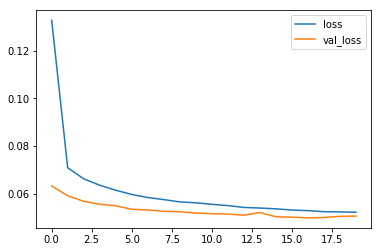

In [29]:
# plot some data
%matplotlib inline

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

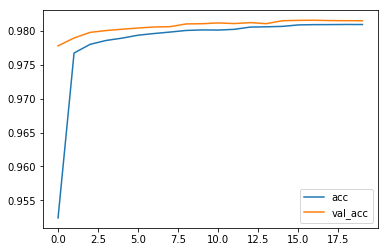

In [30]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [33]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
    
print (aucs)
print(np.mean(aucs))

[0.9788819962592136, 0.9899285046750486, 0.9891950902636295, 0.9701005585349187, 0.9841077704357148, 0.9827548137069199]
0.9824947889792407


In [34]:
# serialize model to JSON
model_json = model.to_json()
with open("lstm_hate_speech.json", "w") as json_file:
	json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("lstm_hate_speech.h5")
print("Saved model to disk")


Saved model to disk
